# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.



In [ ]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import datetime as dt
import matplotlib.dates as mdates
import math



from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, GRU, LSTM
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
df= pd.read_csv('/content/drive/MyDrive/Tuwaiq/Week 5/5- Weekly Project/Day/Traffic Data.csv')
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


## Exploratory Data Analysis (EDA)



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [6]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [72]:
df['date_time'] = pd.to_datetime(df['date_time'])
df.sort_values(by='date_time', inplace=True)

df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00


In [10]:
fig = px.line(df, x=df['date_time'], y=['traffic_volume'], color_discrete_sequence=['#6988c3'],  title='Traffic Volume Over Time')

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='traffic volume',
)
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


### Seasonal decomposition

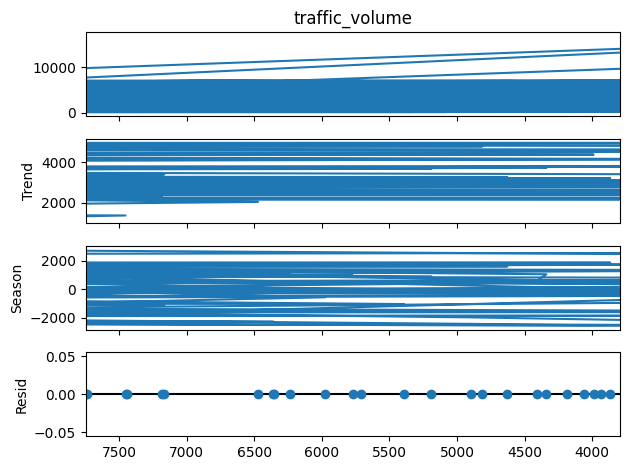

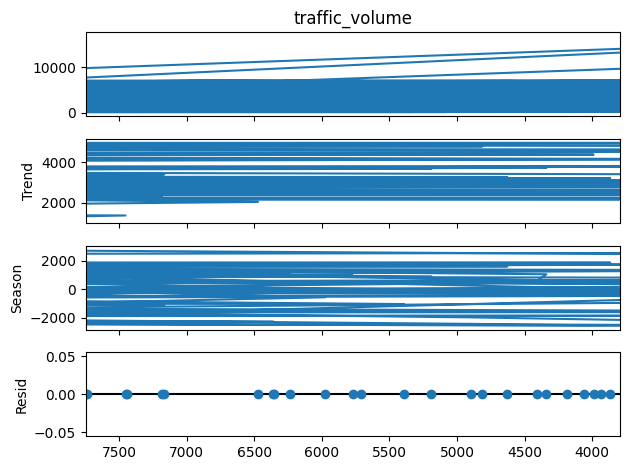

In [77]:
from statsmodels.tsa.seasonal import STL

stl = STL(
    df['traffic_volume'], period=30, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=True
)
res_deg_0 = stl.fit()
res_deg_0.plot()


### outlier

In [11]:
fig = px.box(df, y="traffic_volume" )
fig.show()

In [6]:
# convert outliers to null values then fill them with the mean
df.loc[df['traffic_volume'] >= 10000] = np.nan


## missing values

In [7]:
df.isnull().sum()

,0
traffic_volume,23
temp,3
rain_1h,3
snow_1h,3
clouds_all,3
weather_main,3
weather_description,3
date_time,3


In [8]:
# only handle missing values of traffic_volume, since that's what I'll be using as a feature
df['traffic_volume'].fillna(df['traffic_volume'].mean(), inplace=True)

In [9]:
fig = px.line(df, x=df['date_time'], y=['traffic_volume'], color_discrete_sequence=['#6988c3'],  title='Traffic Volume Over Time')

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='traffic volume',
)
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


## Feature Engineering



### Shift method

In [49]:
new_df = df[['date_time', 'traffic_volume']]
new_df.set_index('date_time', inplace=True)

new_df['prev_traffic_volume'] = new_df['traffic_volume'].shift(1)
new_df.reset_index(inplace=True)

# drop the first row that contain nan value
new_df = new_df.drop(new_df.index[0])
new_df.head()

<ipython-input-49-23b7a6a2eb9b>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date_time,traffic_volume,prev_traffic_volume
1,2016-11-18 15:00:00,4872.0,4872.0
2,2016-11-18 15:00:00,4872.0,4872.0
3,2016-11-18 16:00:00,5074.0,4872.0
4,2016-11-18 16:00:00,5074.0,5074.0
5,2016-11-18 16:00:00,5074.0,5074.0


### Feature engneering

In [36]:
new_df['diff_traffic_volume'] = new_df['traffic_volume'].diff()
# drop the first row that contain nan value
new_df = new_df.drop(new_df.index[0])

new_df['Day_of_week'] = new_df['date_time'].dt.day_of_week
new_df['month'] = new_df['date_time'].dt.month
new_df['Day_of_year'] = new_df['date_time'].dt.day_of_year

new_df.head()


,date_time,traffic_volume,prev_traffic_volume,diff_traffic_volume,Day_of_week,month,Day_of_year
2,2016-11-18 15:00:00,4872.0,4872.0,0.0,4.0,11.0,323.0
3,2016-11-18 16:00:00,5074.0,4872.0,202.0,4.0,11.0,323.0
4,2016-11-18 16:00:00,5074.0,5074.0,0.0,4.0,11.0,323.0
5,2016-11-18 16:00:00,5074.0,5074.0,0.0,4.0,11.0,323.0
6,2016-11-18 17:00:00,4328.0,5074.0,-746.0,4.0,11.0,323.0


In [50]:
new_df.set_index('date_time', inplace=True)

## Train-Test Split



In [51]:
train_split = round(len(new_df) * 0.8)
train_data = new_df.iloc[:train_split]
test_data = new_df.iloc[train_split:]

## Feature Scaling



In [52]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [53]:
train_data_scaled

array([[0.66401563, 0.66401563],
       [0.66401563, 0.66401563],
       [0.69220036, 0.66401563],
       ...,
       [0.36486675, 0.36486675],
       [0.23496582, 0.36486675],
       [0.18236361, 0.23496582]])

In [54]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [55]:
X_train, y_train = create_dataset(train_data_scaled, 24)
X_test, y_test = create_dataset(test_data_scaled, 24)

In [56]:
X_train.shape

(15974, 24, 2)

In [57]:
X_test.shape

(3975, 24, 2)

## Model 1 (LSTM)

In [58]:
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(24, 2)),
    LSTM(50, return_sequences=False),

    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_absolute_error')

model_lstm.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 24, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model_lstm.fit(X_train, y_train, epochs=40 , batch_size= 16, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.1419 - val_loss: 0.0507
Epoch 2/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - loss: 0.0556 - val_loss: 0.0520
Epoch 3/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - loss: 0.0520 - val_loss: 0.0507
Epoch 4/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - loss: 0.0493 - val_loss: 0.0453
Epoch 5/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 0.0460 - val_loss: 0.0435
Epoch 6/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - loss: 0.0452 - val_loss: 0.0435
Epoch 7/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 0.0440 - val_loss: 0.0428
Epoch 8/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - loss: 0.0445 - val_loss: 0.0423
Epoch 9/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 0.0423 - val_loss: 0.0408
Epoch 10/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - loss: 0.0421 - val_loss: 0.0397
Epoch 11/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - loss: 0.0417 - val_loss: 0.0406
Epoch 12/40
999/999 ━━━━━━━━━━

### Evaluation



In [86]:
# predict X_test
predicted_values_test = model_lstm.predict(X_test)

predicted_values_test_reshaped = np.hstack((predicted_values_test, np.zeros((predicted_values_test.shape[0], 1))))
predicted_values_test_rescaled = scaler.inverse_transform(predicted_values_test_reshaped)
predicted_values_test_rescaled = predicted_values_test_rescaled[:, 0]
#y_test
y_test_reshaped = np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))))
testY_rescaled = scaler.inverse_transform(y_test_reshaped)
testY_rescaled = testY_rescaled[:, 0]


# predict X_train
predicted_values_train = model_lstm.predict(X_train)

predicted_values_train_reshaped = np.hstack((predicted_values_train, np.zeros((predicted_values_train.shape[0], 1))))
predicted_values_train_rescaled = scaler.inverse_transform(predicted_values_train_reshaped)
predicted_values_train_rescaled = predicted_values_train_rescaled[:, 0]
#y_train
y_train_reshaped = np.hstack((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 1))))
trainY_rescaled = scaler.inverse_transform(y_train_reshaped)
trainY_rescaled = trainY_rescaled[:, 0]

print(f'Test MAE: {mean_absolute_error(testY_rescaled, predicted_values_test_rescaled)}')
print(f'Train MAE: {mean_absolute_error(trainY_rescaled, predicted_values_train_rescaled)}')



125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Test MAE: 258.0885114306812
Train MAE: 250.63856702331927


In [87]:

data = {'Actual': testY_rescaled[0:500], 'Predicted': predicted_values_test_rescaled[0:500]}
df = pd.DataFrame(data)


fig = px.line(df, x=df.index, y=['Actual', 'Predicted'], title='Traffic Volume Prediction on Test Set (LSTM)')
fig.update_layout(
    yaxis_title='Traffic Volume',
    legend_title='Legend',
)
fig.update_traces(line=dict(color='#6988c3'), selector=dict(name='Actual'))
fig.update_traces(line=dict(color='#fa8c89'), selector=dict(name='Predicted'))


fig.show()

In [90]:

data = {'Actual': trainY_rescaled[0:500], 'Predicted': predicted_values_train_rescaled[0:500]}
df = pd.DataFrame(data)


fig = px.line(df, x=df.index, y=['Actual', 'Predicted'], title='Traffic Volume Prediction on Train Set (LSTM)')
fig.update_layout(
    yaxis_title='Traffic Volume',
    legend_title='Legend',
)
fig.update_traces(line=dict(color='#6988c3'), selector=dict(name='Actual'))
fig.update_traces(line=dict(color='#fa8c89'), selector=dict(name='Predicted'))


fig.show()

## Model 2 (GRU)



In [66]:
model_GRU = Sequential([
    GRU(50, return_sequences=True, input_shape=(24, 2)),
    GRU(50, return_sequences=False),

    Dense(1)
])

model_GRU.compile(optimizer='adam', loss='mean_absolute_error')

model_GRU.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 24, 50)              │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,451 (91.61 KB)

 Trainable params: 23,451 (91.61 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model_GRU.fit(X_train, y_train, epochs=20 , batch_size= 16, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - loss: 0.1046 - val_loss: 0.0524
Epoch 2/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - loss: 0.0557 - val_loss: 0.0552
Epoch 3/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - loss: 0.0518 - val_loss: 0.0462
Epoch 4/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - loss: 0.0493 - val_loss: 0.0509
Epoch 5/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - loss: 0.0483 - val_loss: 0.0468
Epoch 6/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - loss: 0.0451 - val_loss: 0.0472
Epoch 7/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - loss: 0.0442 - val_loss: 0.0409
Epoch 8/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0432 - val_loss: 0.0539
Epoch 9/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 0.0436 - val_loss: 0.0419
Epoch 10/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0424 - val_loss: 0.0396
Epoch 11/20
999/999 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - loss: 0.0422 - val_loss: 0.0412
Epoch 12/20
999/999 ━━━━━━━━━━

### Evaluation



In [91]:
# predict X_test
predicted_values_test = model_GRU.predict(X_test)

predicted_values_test_reshaped = np.hstack((predicted_values_test, np.zeros((predicted_values_test.shape[0], 1))))
predicted_values_test_rescaled = scaler.inverse_transform(predicted_values_test_reshaped)
predicted_values_test_rescaled = predicted_values_test_rescaled[:, 0]
#y_test
y_test_reshaped = np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))))
testY_rescaled = scaler.inverse_transform(y_test_reshaped)
testY_rescaled = testY_rescaled[:, 0]


# predict X_train
predicted_values_train = model_GRU.predict(X_train)

predicted_values_train_reshaped = np.hstack((predicted_values_train, np.zeros((predicted_values_train.shape[0], 1))))
predicted_values_train_rescaled = scaler.inverse_transform(predicted_values_train_reshaped)
predicted_values_train_rescaled = predicted_values_train_rescaled[:, 0]
#y_train
y_train_reshaped = np.hstack((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 1))))
trainY_rescaled = scaler.inverse_transform(y_train_reshaped)
trainY_rescaled = trainY_rescaled[:, 0]

print(f'Test MAE: {mean_absolute_error(testY_rescaled, predicted_values_test_rescaled)}')
print(f'Train MAE: {mean_absolute_error(trainY_rescaled, predicted_values_train_rescaled)}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
Test MAE: 280.0367756794881
Train MAE: 289.1249062607441


In [92]:

data = {'Actual': testY_rescaled[0:500], 'Predicted': predicted_values_test_rescaled[0:500]}
df = pd.DataFrame(data)


fig = px.line(df, x=df.index, y=['Actual', 'Predicted'], title='Traffic Volume Prediction on Test Set (GRU)')
fig.update_layout(
    yaxis_title='Traffic Volume',
    legend_title='Legend',
)
fig.update_traces(line=dict(color='#6988c3'), selector=dict(name='Actual'))
fig.update_traces(line=dict(color='#fa8c89'), selector=dict(name='Predicted'))


fig.show()

In [93]:

data = {'Actual': trainY_rescaled[0:500], 'Predicted_train': predicted_values_train_rescaled[0:500]}
df = pd.DataFrame(data)


fig = px.line(df, x=df.index, y=['Actual', 'Predicted_train'], title='Traffic Volume Prediction on Train Set (GRU)')
fig.update_layout(
    yaxis_title='Traffic Volume',
    legend_title='Legend',
)
fig.update_traces(line=dict(color='#6988c3'), selector=dict(name='Actual'))
fig.update_traces(line=dict(color='#fa8c89'), selector=dict(name='Predicted_train'))


fig.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values).
How did these techniques help prepare the data for training the model?

- the model dose not except vdata wit null values , normalization helps model perform better and faster and save computation power


2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
- yes i did, i used shift technique, i also tried other features like day_of_week.. but they make the model during fitting display a nan so i did not use them


3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?

- LSTM and GRU designed to handle time series data with a memory feature


4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?

-  I choosed MAE, it tell how many traffic valum the model may mistake on counting them
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?


7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?

- Using dropout


8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.